## 卷积神经网络 Task7

* 卷积运算的定义、动机（稀疏权重、参数共享、等变表示）。一维卷积运算和二维卷积运算。
* 反卷积(tf.nn.conv2d_transpose)
* 池化运算的定义、种类（最大池化、平均池化等）、动机。
* Text-CNN的原理。
* 利用Text-CNN模型来进行文本分类。



In [ ]:
'''
卷积运算的定义、动机（稀疏权重、参数共享、等变表示）。一维卷积运算和二维卷积运算。

卷积运算: 与经典的全连接神经网络相比，卷积神经网络运算的原理是通过加入卷积层和池化层，
来对特征进行逐步细化浓缩提取。
实现方式是通过滑动窗口的方式，在原始数据中划分出一个小区域矩阵，
在卷积层conv层与通过窗口filter取前一层特征图上的小区域与下一层神经元做内积和操作(即wx+b)，
经激活函数将线性转为非线性结果，
将结果，即提取的特征点汇到一个特征图，
再通过池化层pooling层 根据求max或mean操作，保留一个特征数，将特征图浓缩，
再经过下一层卷积，池化，逐步浓缩，细化特征，
最后经过两个全连接层整合特征，再softmax把特征分类。
filter在取前一层数据小窗口时，是滑动向前依次提取，
由stride指定每次滑动多远。

稀疏权重：又叫稀疏连接，就是指上面说到的，每次只关注和处理视觉范围前后的影象。
稀疏即散布离散，相对非连续性的一个概念。

参数共享：因为每个特征图小窗口在与下一层神经元做内积和操作进行wx+b操作时都带有一个w,
有多少个神经元就有多少个w，把相同的w共享避免大量操作，这个过程叫参数共享

等变表示: 等比变化，可以通过局部特性按照规律，
映射出整体或其它部分（如通过正脸特征映射画出侧脸）的特征，
反之也可以从整体抽离局部特征浓缩代表整体，等变特性是上面卷积得以实现的依据。

一维卷积运算：比如图象RGB通道，只有一个，灰度图，算上面卷积运算时只对一个平面，
做filter过滤小窗口提取特征，再pooling压缩等操作。

二维护卷积运算：chanel加入一个深度，比如图片识别的特征提取，一张彩色图，
有三个颜色通道RGB，即，输入就是 长X宽X3,3就是深度。
后面对应的filter也是三个分别提取三个通道的特征。

反卷积(tf.nn.conv2d_transpose)：
反卷积操作是卷积的反向，指上面conv pooling 一系列完成得到最终结果后，
反向传播回来求梯度使loss操失最小，来取最合适的参数w,b的操作。

tensorflow的conv2d_transpose函数可以实现反卷积，参数介绍如下：
tf.nn.conv2d_transpose(
value, #输入值，需要反卷积的输入，即从后一层反传回来的梯度值，要求tensor格式
filter, #卷积核，tensor格式，四维[f高，f宽，f个数，chanel深度或图像通道数]
output_shape, #输出的shape
strides, #滑动尺度，每一维滑动的步长
padding="SAME", #边缘填充：滑动窗口到边缘，有空出位补0操作，为了提取完整特征。VALID是舍弃这部分特征。
data_format="NHWC", #输入参数的格式，默认NHWC顺序，即[batch, height, width, in_channels]
)

池化运算的定义、种类（最大池化、平均池化等）、动机。

池化运算: 池化操作是在卷积后面跟着的一层将特征图filter提取的小区域按照规则，
取最大Max或取平均Mean来 保留一个代表性矩阵值。
动机：对特征进一步压缩细化。
这一步和卷积层的实现原理一样，只是没有wx+b 内积和 操作。
最大池化：Max，取前一层特征矩阵中最大值，如[[1,2][4,5]] 只取5放入特征图中。
平均池化：mean,前一层特征矩阵中多个值取平均产，如[[1,2][4,5]] 取 （1+2+4+5）/4 = 6

Text-CNN的原理:

TextCNN 是利用卷积神经网络对文本进行分类的算法。
卷积具有局部特征提取的功能, 所以可用 CNN 来提取句子中类似 n-gram （中心词前后的词组对）的关键信息。

Text-CNN与CNN处理图象的对比：

处理图像数据，CNN的filter卷积核宽高一致，自己指定
但Text-CNN 因为是以词为最小颗粒滑动，所以filter滑动窗口的宽度（卷积核宽），
不能自己指定（不能把一个词像图片一个拆碎了就没有意义了），
所以Text-CNN filter宽度要与词向量的维度一致，之前输入的每一行向量代表一个词，
高度可以自行指定，filter滑动卷积时提取特征时考虑了词义同时考虑了词序及其上下文,
相当于取n-gram操作（类似CBOW 由上下文算中心词概率,skip-gram 由中心词算上下文思想），
可以使用多个filter，设置不同的高度，提取多重特征 （比如使用多组filter等价于 uni-gram bi-gram tri-gram操作）。

上面是卷积层，卷积后relu激活函数转线性为非线性数据，
池化层Text-CNN是取一个Max，最重要的特征向量，

再下一层conv,relu,pooling……

最后在全连接层把每个特征值拼接起来(前面加一层dropout防过拟和)。

再经过softmax分类。

'''

In [3]:
'''
利用Text-CNN模型来进行文本分类。
cnn手写字体识别
'''
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
#初始化tensorflow 读取数据类

In [4]:
#读取minist数据集
mnist = input_data.read_data_sets('MinistData',one_hot=True)
#数据已下载，存在同目录MinistData文件夹下



Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MinistData\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MinistData\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MinistData\t10k-images-idx3-ubyte.gz
Extracting MinistData\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [7]:
print("训练集数据个数：",mnist.train.num_examples)
print("验证集数据个数：",mnist.validation.num_examples)
print("测试集数据个数：",mnist.test.num_examples)

训练集数据个数： 55000
验证集数据个数： 5000
测试集数据个数： 10000


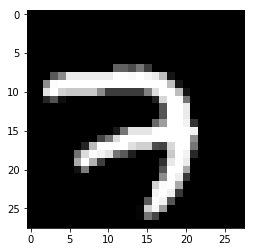

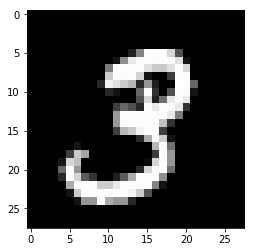

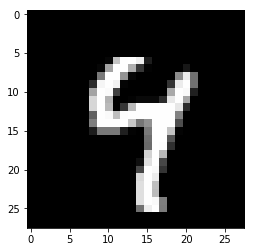

In [39]:
trainDatas = mnist.train.images
trainLabels = mnist.train.labels
testDatas = mnist.test.images
testLabels = mnist.test.labels
#显示图看下
plt.figure()
for i in range(3):
    plt.imshow(trainDatas[i].reshape(28,28),'gray')
    plt.pause(0.0000001)
plt.show()
#更多本数据集操作见
#https://blog.csdn.net/panrenlong/article/details/81736754

In [40]:
#数据初始化
n_input = 784
n_output = 10
#定义两层conv卷积，两层全连接层fc1，fc2
weights = {
    'wc1':tf.Variable(tf.truncated_normal([3,3,1,64],stddev=0.1)),
    'wc2':tf.Variable(tf.truncated_normal([3,3,64,128],stddev=0.1)),
    'wd1':tf.Variable(tf.truncated_normal([7*7*128,1024],stddev=0.1)),
    'wd2':tf.Variable(tf.truncated_normal([1024,n_output],stddev=0.1))
}
#参数解释wc1 [3,3,1,64]#filter的高h,宽w,深度1为灰度图RGB通道一条，输出64个特征图
#wc2[3,3,64,128] #filter高，宽，深64（前一层传过来的64个），输出特征图128个

#定义偏置项
biases = {
    'bc1':tf.Variable(tf.random_normal([64],stddev=0.1)),
    'bc2':tf.Variable(tf.random_normal([128],stddev=0.1)),
    'bd1':tf.Variable(tf.random_normal([1024],stddev=0.1)),
    'bd2':tf.Variable(tf.random_normal([n_output],stddev=0.1))
}

In [41]:
#卷积加池化操作函数
def conv_basic(_input,_w,_b,_keepratio):
    #前向传播
    #数据预处理,将输入的数据变成tensorflow需要的四维格式
    _input_r = tf.reshape(_input,shape=[-1,28,28,1])
    #参数：batchsize，没有的话设1，-1 tf会根据后三项自动算
        #h高度，w宽度，chanel RGB 通道1灰度
    
    #用conv2d进行卷积，代入参数
    _conv1 = tf.nn.conv2d(_input_r,_w['wc1'],strides=[1,1,1,1],padding='SAME')
    #参数：_w['wc1']为上面定义的字典取值第一层w
        #strides 滑动步长 要求四维格式[输入,h,w,chanel]主要 改中间两个h w
        #padding='SAME' 滑到边缘有空值时补0
    
    #给上面卷积层加relu激活函数，转非线性
    _conv1 = tf.nn.relu(tf.nn.bias_add(_conv1,_b['bc1']))
    #relu里面是一个wx+b操作
    
    #加池化层Max-pooling
    _pool1 = tf.nn.max_pool(_conv1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    #参数：ksize = [1,2,2,1]#2*2窗口
        #strides 滑动步长
    
    #加一层dropout，防过拟和（通过弃用不重要特征的方式）
    _pool_dr1 = tf.nn.dropout(_pool1,_keepratio)
    #_keepratio杀死比例
    
    #再定义一层卷积
    _conv2 = tf.nn.conv2d(_pool_dr1,_w['wc2'],strides=[1,1,1,1],padding='SAME')
    #加relu激活函数
    _conv2 = tf.nn.relu(tf.nn.bias_add(_conv2,_b['bc2']))
    
    #二层池化层
    _pool2 = tf.nn.max_pool(_conv2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    #加dropout
    _pool_dr2 = tf.nn.dropout(_pool2,_keepratio)
    
    #拼接整理特征图
    _dense1 = tf.reshape(_pool_dr2,[-1,_w['wd1'].get_shape().as_list()[0]])
    #_w['wd1']用上面字典中定义好的骨架
    
    #全连接一层fc1
    _fc1 = tf.nn.relu(tf.add(tf.matmul(_dense1,_w['wd1']),_b['bd1']))
    #与上一层输入x即 _dense1特征图，执行wx+b操作，再relu
    #加dropout
    _fc_dr1 = tf.nn.dropout(_fc1,_keepratio)
                      
    #第二层全连接层fc2，这里用_out表示了
    _out = tf.add(tf.matmul(_fc_dr1,_w['wd2']),_b['bd2'])
    #wx+b,累加
    
    #组合上面信息返回值
    out = {
        'input_r':_input_r,
        'conv1':_conv1,
        'pool1':_pool1,
        'pool_dr1':_pool_dr1,
        'conv2':_conv2,
        'pool2':_pool2,
        'pool_dr2':_pool_dr2,
        'dense1':_dense1,
        'fc1':_fc1,
        'fc_dr1':_fc_dr1,
        'out':_out
    }
    
    return out
    

In [42]:
#处理tf相关操作
a = tf.Variable(tf.random_normal([3,3,1,64],stddev=0.1))
#print(a)
a = tf.Print(a,[a],"a:")
#初始化tf变量
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [44]:
x = tf.placeholder(tf.float32,[None,n_input])
y = tf.placeholder(tf.float32,[None,n_output])
keepratio = tf.placeholder(tf.float32)

_pred = conv_basic(x,weights,biases,keepratio)['out']
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=_pred,labels=y))
#`softmax_cross_entropy_with_logits`参数格式 (labels=..., logits=..., ...)
optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
_corr = tf.equal(tf.argmax(_pred,1),tf.argmax(y,1))
#比较预测值与真实例相等则正确
accr = tf.reduce_mean(tf.cast(_corr,tf.float32))

#tf变量初始化
init = tf.global_variables_initializer()


In [49]:
#迭代执行上面函数
sess = tf.Session()
sess.run(init)
training_epochs = 15
batch_size = 16
display_step = 1

for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = 10
    for i in range(total_batch):
        batch_xs,batch_ys = mnist.train.next_batch(batch_size)
        #【训练数据是从这里传进去的，mnist.train 自动划分了x和y】
        sess.run(optm,feed_dict={x:batch_xs,y:batch_ys,keepratio:0.7})
        avg_cost += sess.run(cost,feed_dict={x:batch_xs,y:batch_ys,keepratio:1.})/total_batch
        
    if epoch % display_step == 0:
        print("第 %s 次迭代，共 %s 次，平均损失: %.9f " % (epoch+1,training_epochs,avg_cost))
        train_acc = sess.run(accr,feed_dict={x:batch_xs,y:batch_ys,keepratio:1.})
        print("训练精确度：%.9f" % train_acc)
        #显示小数点位数%.3f 3位，注意前面不是%s.3f
        

第 1 次迭代，共 15 次，平均损失: 5.714303398 
训练精确度：0.125000000
第 2 次迭代，共 15 次，平均损失: 2.583076143 
训练精确度：0.062500000
第 3 次迭代，共 15 次，平均损失: 2.250749660 
训练精确度：0.125000000
第 4 次迭代，共 15 次，平均损失: 2.132968116 
训练精确度：0.500000000
第 5 次迭代，共 15 次，平均损失: 2.019559205 
训练精确度：0.562500000
第 6 次迭代，共 15 次，平均损失: 1.710370076 
训练精确度：0.750000000
第 7 次迭代，共 15 次，平均损失: 1.180212092 
训练精确度：0.750000000
第 8 次迭代，共 15 次，平均损失: 0.928154027 
训练精确度：0.687500000
第 9 次迭代，共 15 次，平均损失: 0.692349124 
训练精确度：0.937500000
第 10 次迭代，共 15 次，平均损失: 0.717520785 
训练精确度：0.812500000
第 11 次迭代，共 15 次，平均损失: 0.619076169 
训练精确度：0.812500000
第 12 次迭代，共 15 次，平均损失: 0.580044615 
训练精确度：0.812500000
第 13 次迭代，共 15 次，平均损失: 0.650347844 
训练精确度：0.937500000
第 14 次迭代，共 15 次，平均损失: 0.590193996 
训练精确度：0.875000000
第 15 次迭代，共 15 次，平均损失: 0.562588316 
训练精确度：0.875000000


In [55]:
# -*- coding= utf-8 -*-
#embedding_lookup用法，通过embedding_lookup用法来实现窗口扫描文本
import tensorflow as tf
import numpy as np

a = [[0.1, 0.2, 0.3], [1.1, 1.2, 1.3], [2.1, 2.2, 2.3], [3.1, 3.2, 3.3], [4.1, 4.2, 4.3]]
a = np.asarray(a)
idx1 = tf.Variable([0, 2, 3, 1], tf.int32)
idx2 = tf.Variable([[0, 2, 3, 1], [4, 0, 2, 2]], tf.int32)
out1 = tf.nn.embedding_lookup(a, idx1)
out2 = tf.nn.embedding_lookup(a, idx2)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    print( sess.run(out1))
    print(out1)
    print('==================')
    print(sess.run(out2))
    print(out2)

[[0.1 0.2 0.3]
 [2.1 2.2 2.3]
 [3.1 3.2 3.3]
 [1.1 1.2 1.3]]
Tensor("embedding_lookup:0", shape=(4, 3), dtype=float64)
[[[0.1 0.2 0.3]
  [2.1 2.2 2.3]
  [3.1 3.2 3.3]
  [1.1 1.2 1.3]]

 [[4.1 4.2 4.3]
  [0.1 0.2 0.3]
  [2.1 2.2 2.3]
  [2.1 2.2 2.3]]]
Tensor("embedding_lookup_1:0", shape=(2, 4, 3), dtype=float64)


In [56]:
#Text-CNN,即cnn对文本的处理

import tensorflow as tf
import numpy as np

#文本卷积函数
class TextCNN(object):
    """
    cnn对文本的处理
    输入层, 卷积层, 池化层，softmax连接层.
    """

    def __init__(
      self, sequence_length, num_classes, vocab_size,
      embedding_size, filter_sizes, num_filters, l2_reg_lambda=0.0):

        # 初始化：sequence_length为词的长度
        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        # l2正则惩罚项
        l2_loss = tf.constant(0.0)

        # 输入层
        with tf.device('/cpu:0'), tf.name_scope("embedding"):
            self.W = tf.Variable(
                tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0),
                name="W")
            self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

        #为每个filter 卷积和 建 卷积层、池化层
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                # 建卷积层，通过tf的conv2d开始卷积
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(
                    self.embedded_chars_expanded,
                    W,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
                # 加激活函数
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                # 加池化层
                pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, sequence_length - filter_size + 1, 1, 1],
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name="pool")
                pooled_outputs.append(pooled)

        # 组合特征
        num_filters_total = num_filters * len(filter_sizes)
        self.h_pool = tf.concat(pooled_outputs, 3)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])

        # 填加dropout防止过拟和
        with tf.name_scope("dropout"):
            self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)

        # 预测
        with tf.name_scope("output"):
            W = tf.get_variable(
                "W",
                shape=[num_filters_total, num_classes],
                initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name="scores")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")

        # 计算损失值
        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss

        # 计算精确度
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")

In [73]:
#读取数据
import numpy as np
import re
import itertools
from collections import Counter


def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    # 清理数据替换掉无词义的符号
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()


def load_data_and_labels(positive_data_file, negative_data_file):
    """
    Loads MR polarity data from files, splits the data into words and generates labels.
    Returns split sentences and labels.
    """
    # Load data from files


    positive = open(positive_data_file, "rb").read().decode('utf-8')
    negative = open(negative_data_file, "rb").read().decode('utf-8')

    # 按回车分割样本
    positive_examples = positive.split('\n')[:-1]
    negative_examples = negative.split('\n')[:-1]

    # 去空格
    positive_examples = [s.strip() for s in positive_examples]
    negative_examples = [s.strip() for s in negative_examples]

    #positive_examples = list(open(positive_data_file, "rb").read().decode('utf-8'))
    #positive_examples = [s.strip() for s in positive_examples]
    #negative_examples = list(open(negative_data_file, "rb").read().decode('utf-8'))
    #negative_examples = [s.strip() for s in negative_examples]
    # Split by words
    x_text = positive_examples + negative_examples
    x_text = [clean_str(sent) for sent in x_text] # 字符过滤，实现函数见clean_str()
    # Generate labels
    positive_labels = [[0, 1] for _ in positive_examples]
    negative_labels = [[1, 0] for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0) # 将两种label连在一起
    return [x_text, y]

# 创建batch迭代模块
def batch_iter(data, batch_size, num_epochs, shuffle=True): # shuffle=True洗牌
    """
    Generates a batch iterator for a dataset.
    """
    # 每次只输出shuffled_data[start_index:end_index]这么多
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1 # 每一个epoch有多少个batch_size
    for epoch in range(num_epochs):
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size)) # 洗牌
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size # 当前batch的索引开始
            end_index = min((batch_num + 1) * batch_size, data_size) # 判断下一个batch是不是超过最后一个数据了
            yield shuffled_data[start_index:end_index]


In [ ]:
#训练迭代
import tensorflow as tf
import numpy as np
import os
import time
import datetime
from tensorflow.contrib import learn

# Parameters
# ==================================================

# Data loading params
# 语料文件路径定义
tf.flags.DEFINE_float("dev_sample_percentage", .1, "Percentage of the training data to use for validation")
tf.flags.DEFINE_string("positive_data_file", "./data/rt-polaritydata/rt-polarity.pos", "Data source for the positive data.")
tf.flags.DEFINE_string("negative_data_file", "./data/rt-polaritydata/rt-polarity.neg", "Data source for the negative data.")

# Model Hyperparameters
# 定义网络超参数
tf.flags.DEFINE_integer("embedding_dim", 128, "Dimensionality of character embedding (default: 128)")
tf.flags.DEFINE_string("filter_sizes", "3,4,5", "Comma-separated filter sizes (default: '3,4,5')")
tf.flags.DEFINE_integer("num_filters", 128, "Number of filters per filter size (default: 128)")
tf.flags.DEFINE_float("dropout_keep_prob", 0.5, "Dropout keep probability (default: 0.5)")
tf.flags.DEFINE_float("l2_reg_lambda", 0.0, "L2 regularization lambda (default: 0.0)")

# Training parameters
# 训练参数
tf.flags.DEFINE_integer("batch_size", 32, "Batch Size (default: 32)")
tf.flags.DEFINE_integer("num_epochs", 200, "Number of training epochs (default: 200)") # 总训练次数
tf.flags.DEFINE_integer("evaluate_every", 100, "Evaluate model on dev set after this many steps (default: 100)") # 每训练100次测试一下
tf.flags.DEFINE_integer("checkpoint_every", 100, "Save model after this many steps (default: 100)") # 保存一次模型
tf.flags.DEFINE_integer("num_checkpoints", 5, "Number of checkpoints to store (default: 5)")
# Misc Parameters
tf.flags.DEFINE_boolean("allow_soft_placement", True, "Allow device soft device placement") # 加上一个布尔类型的参数，要不要自动分配
tf.flags.DEFINE_boolean("log_device_placement", False, "Log placement of ops on devices") # 加上一个布尔类型的参数，要不要打印日志

# 打印一下相关初始参数
FLAGS = tf.flags.FLAGS
FLAGS._parse_flags()
print("\nParameters:")
for attr, value in sorted(FLAGS.__flags.items()):
    print("{}={}".format(attr.upper(), value))
print("")


# Data Preparation
# ==================================================

# Load data
print("Loading data...")
x_text, y = load_data_and_labels(FLAGS.positive_data_file, FLAGS.negative_data_file)

# Build vocabulary
max_document_length = max([len(x.split(" ")) for x in x_text]) # 计算最长邮件
vocab_processor = learn.preprocessing.VocabularyProcessor(max_document_length) # tensorflow提供的工具，将数据填充为最大长度，默认0填充
x = np.array(list(vocab_processor.fit_transform(x_text)))

# Randomly shuffle data
# 数据洗牌
np.random.seed(10)
# np.arange生成随机序列
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

# 将数据按训练train和测试dev分块
# Split train/test set
# TODO: This is very crude, should use cross-validation
dev_sample_index = -1 * int(FLAGS.dev_sample_percentage * float(len(y)))
x_train, x_dev = x_shuffled[:dev_sample_index], x_shuffled[dev_sample_index:]
y_train, y_dev = y_shuffled[:dev_sample_index], y_shuffled[dev_sample_index:]
print("Vocabulary Size: {:d}".format(len(vocab_processor.vocabulary_)))
print("Train/Dev split: {:d}/{:d}".format(len(y_train), len(y_dev))) # 打印切分的比例


# Training
# ==================================================

with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
        allow_soft_placement=FLAGS.allow_soft_placement,
        log_device_placement=FLAGS.log_device_placement)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        # 卷积池化网络导入
        cnn = TextCNN(
            sequence_length=x_train.shape[1],
            num_classes=y_train.shape[1], # 分几类
            vocab_size=len(vocab_processor.vocabulary_),
            embedding_size=FLAGS.embedding_dim,
            filter_sizes=list(map(int, FLAGS.filter_sizes.split(","))), # 上面定义的filter_sizes拿过来，"3,4,5"按","分割
            num_filters=FLAGS.num_filters, # 一共有几个filter
            l2_reg_lambda=FLAGS.l2_reg_lambda) # l2正则化项

        # Define Training procedure
        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdamOptimizer(1e-3) # 定义优化器
        grads_and_vars = optimizer.compute_gradients(cnn.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

        # Keep track of gradient values and sparsity (optional)
        grad_summaries = []
        for g, v in grads_and_vars:
            if g is not None:
                grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                grad_summaries.append(grad_hist_summary)
                grad_summaries.append(sparsity_summary)
        grad_summaries_merged = tf.summary.merge(grad_summaries)

        # Output directory for models and summaries
        timestamp = str(int(time.time()))
        out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
        print("Writing to {}\n".format(out_dir))

        # Summaries for loss and accuracy
        # 损失函数和准确率的参数保存
        loss_summary = tf.summary.scalar("loss", cnn.loss)
        acc_summary = tf.summary.scalar("accuracy", cnn.accuracy)

        # Train Summaries
        # 训练数据保存
        train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

        # Dev summaries
        # 测试数据保存
        dev_summary_op = tf.summary.merge([loss_summary, acc_summary])
        dev_summary_dir = os.path.join(out_dir, "summaries", "dev")
        dev_summary_writer = tf.summary.FileWriter(dev_summary_dir, sess.graph)

        # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
        checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
        checkpoint_prefix = os.path.join(checkpoint_dir, "model")
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        saver = tf.train.Saver(tf.global_variables(), max_to_keep=FLAGS.num_checkpoints) # 前面定义好参数num_checkpoints

        # Write vocabulary
        vocab_processor.save(os.path.join(out_dir, "vocab"))

        # Initialize all variables
        sess.run(tf.global_variables_initializer()) # 初始化所有变量

        # 定义训练函数
        def train_step(x_batch, y_batch):
            """
            A single training step
            """
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: FLAGS.dropout_keep_prob # 参数在前面有定义
            }
            _, step, summaries, loss, accuracy = sess.run(
                [train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy], feed_dict)
            time_str = datetime.datetime.now().isoformat() # 取当前时间，python的函数
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            train_summary_writer.add_summary(summaries, step)

        # 定义测试函数
        def dev_step(x_batch, y_batch, writer=None):
            """
            Evaluates model on a dev set
            """
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: 1.0 # 神经元全部保留
            }
            step, summaries, loss, accuracy = sess.run(
                [global_step, dev_summary_op, cnn.loss, cnn.accuracy], feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            if writer:
                writer.add_summary(summaries, step)

        # Generate batches
        batches = batch_iter(list(zip(x_train, y_train)), FLAGS.batch_size, FLAGS.num_epochs)
        # Training loop. For each batch...
        # 训练部分
        for batch in batches:
            x_batch, y_batch = zip(*batch) # 按batch把数据拿进来
            train_step(x_batch, y_batch)
            current_step = tf.train.global_step(sess, global_step) # 将Session和global_step值传进来
            if current_step % FLAGS.evaluate_every == 0: # 每FLAGS.evaluate_every次每100执行一次测试
                print("\nEvaluation:")
                dev_step(x_dev, y_dev, writer=dev_summary_writer)
                print("")
            if current_step % FLAGS.checkpoint_every == 0: # 每checkpoint_every次执行一次保存模型
                path = saver.save(sess, './', global_step=current_step) # 定义模型保存路径
                print("Saved model checkpoint to {}\n".format(path))

#【待调试】